Referencias:

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [599]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from IPython.display import Math

In [600]:
env = gym.make('FrozenLake-v0')
print(env.observation_space.n)
print(env.action_space.n)
env.render()

16
4

SFFF
FHFH
FFFH
HFFG


In [598]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
)

Error: Cannot re-register id: FrozenLakeNotSlippery-v1

In [601]:
env_not_slippery = gym.make('FrozenLakeNotSlippery-v1')

In [602]:
# 0 -> Left
# 1 -> Down
# 2 -> Right
# 3 -> Up
holes = (np.array([1,1,2,3]),np.array([1,3,3,0]))
controls = []
controls.append('L')
controls.append('D')
controls.append('R')
controls.append('U')
controls = np.array(controls)

action = {action:i for i, action in enumerate(controls)}

In [603]:
s0 = env.reset()

In [604]:
s1,r,d,prob = env.step(action['L'])
print(s1,r,d,prob)
env.render()

0 0.0 False {'prob': 0.3333333333333333}
  (Left)
SFFF
FHFH
FFFH
HFFG


In [605]:
i = 10
np.random.randn(1,env.action_space.n)*(1./(i+1))

array([[ 0.07797069,  0.12409252, -0.02611613,  0.21545335]])

# Table

In [606]:
def estimate_Q(env, num_episodes = 500, lr = .8, y = .95, MA_window = 200, debug = False):
    #lr -> Learning rate
    #y -> Discounted reward coeficient
    #num_episodes -> Iterations
    #MA_window -> Moving Average window for averaging rewards
    
    #Initialize table with all zeros
    Q = np.zeros([env.observation_space.n,env.action_space.n])
    # Set learning parameters
    #create lists to contain total rewards and steps per episode
    #jList = []
    rList = []

    acummulated_average = []
    
    for i in range(num_episodes):
        started = False
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 99:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            #Update Q-Table with new knowledge
            # np.max(Q[s1,:]) -> Cual de todas las acciones tiene mayor valor cuando estoy en el esstado 
            # r + y*np.max(Q[s1,:]) -> Estimated discounted reward
            Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])

            rAll += r
            if debug:
                if (Q[s,a]>0) & (not started):
                    print('episode:',i)
                    started=True
                if started:
                    print('desde:',s,', hasta:',s1,', accion:',controls[a],', Q:', Q[s,a], ', reward:',r)
                    if d:
                        print('Finish!:', rAll)
            s = s1
            if d == True:
                break
        #jList.append(j)
        rList.append(rAll)
        acummulated_average.append(float(sum(rList[-MA_window:]))/MA_window)
    return Q, acummulated_average, rList

In [607]:
def plot_policy(Q):
    zero_Q = np.sum(Q, axis = 1).reshape(4,4) == 0
    policy = np.array(controls)[np.argmax(Q, axis=1)].reshape(4,4)
    policy[zero_Q] = 'X'
    policy[holes] = 'H'
    print(policy)
    
def show_results(Q, acummulated_average):
    plt.plot(acummulated_average)
    plt.xlabel('Episodes')
    plt.ylabel('Wining Average')
    plt.show()
    display(Math('$Q(s_i,a_j)$'))
    print(Q)
    display(Math('$V(s_j) = max_{a_j} Q(s_i,a_j)$'))
    print(np.max(Q, axis=1).reshape(4,4))
    display(Math('$a_j = \pi(s_i) = argmax_{a_j} Q(s_i,a_j)$'))
    plot_policy(Q)

## Non-Slippery
### y=1, lr =1

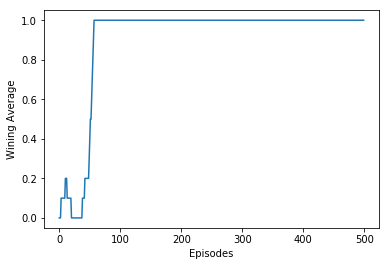

<IPython.core.display.Math object>

[[ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]


<IPython.core.display.Math object>

[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  1.  1.  0.]
 [ 0.  1.  1.  0.]]


<IPython.core.display.Math object>

[['D' 'X' 'X' 'X']
 ['D' 'H' 'X' 'H']
 ['R' 'D' 'L' 'H']
 ['H' 'R' 'R' 'X']]


In [623]:
num_episodes = 500
Q_ns_table, acummulated_average_ns_table, rList = estimate_Q(env_not_slippery, 
                                                             num_episodes=num_episodes, 
                                                             y = 1, MA_window = 10, 
                                                             debug=False, 
                                                            lr = 1)
show_results(Q_ns_table, acummulated_average_ns_table)

### y=1, lr =0.01

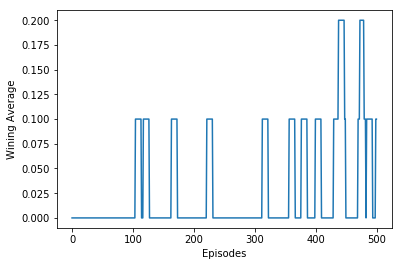

<IPython.core.display.Math object>

[[  3.36555594e-07   9.17249485e-07   4.50598708e-07   3.12557249e-07]
 [  1.65952442e-07   0.00000000e+00   1.56113872e-06   1.98027720e-07]
 [  1.52605224e-07   9.29975823e-06   3.40070226e-08   9.95457337e-07]
 [  4.39566970e-07   0.00000000e+00   9.60438715e-09   1.51503439e-08]
 [  3.48969926e-07   2.70718827e-06   0.00000000e+00   1.72637863e-07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.87995343e-04   0.00000000e+00   1.10187148e-07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.67109148e-06   0.00000000e+00   1.62336167e-05   2.04021636e-07]
 [  6.09314791e-07   1.23482898e-04   1.36818614e-04   0.00000000e+00]
 [  1.73516220e-06   6.60055517e-03   0.00000000e+00   1.90041443e-06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.80171046e-05   3.23820608e-03   2.82096323e-07]
 [  0.

<IPython.core.display.Math object>

[[  9.17249485e-07   1.56113872e-06   9.29975823e-06   4.39566970e-07]
 [  2.70718827e-06   0.00000000e+00   1.87995343e-04   0.00000000e+00]
 [  1.62336167e-05   1.36818614e-04   6.60055517e-03   0.00000000e+00]
 [  0.00000000e+00   3.23820608e-03   1.39941645e-01   0.00000000e+00]]


<IPython.core.display.Math object>

[['D' 'R' 'D' 'L']
 ['D' 'H' 'D' 'H']
 ['R' 'R' 'D' 'H']
 ['H' 'R' 'R' 'X']]


In [631]:
num_episodes = 500
Q_ns_table, acummulated_average_ns_table, rList = estimate_Q(env_not_slippery, 
                                                             num_episodes=num_episodes, 
                                                             y = 1, MA_window = 10, 
                                                             debug=False, 
                                                            lr = 0.01)
show_results(Q_ns_table, acummulated_average_ns_table)

### y=0.9, lr = 0.8

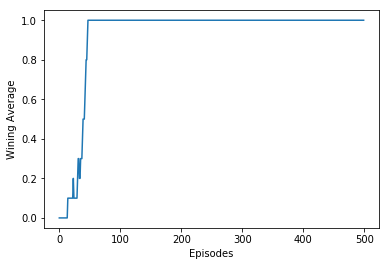

<IPython.core.display.Math object>

[[ 0.       0.       0.59049  0.     ]
 [ 0.       0.       0.6561   0.     ]
 [ 0.       0.729    0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.81     0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.9      0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       1.       0.     ]
 [ 0.       0.       0.       0.     ]]


<IPython.core.display.Math object>

[[ 0.59049  0.6561   0.729    0.     ]
 [ 0.       0.       0.81     0.     ]
 [ 0.       0.       0.9      0.     ]
 [ 0.       0.       1.       0.     ]]


<IPython.core.display.Math object>

[['R' 'R' 'D' 'X']
 ['X' 'H' 'D' 'H']
 ['X' 'X' 'D' 'H']
 ['H' 'X' 'R' 'X']]


In [457]:
# Si 'y' es bajo, los valores de Q tardan mas en pasar 
# np.random.randn(1,env.action_space.n)*(1./(i+1))
num_episodes = 500
Q_ns_table_1, acummulated_average_ns_table_1, _ = estimate_Q(env_not_slippery, 
                                           num_episodes=num_episodes, 
                                           y = 0.9, MA_window = 10, debug=False)
show_results(Q_ns_table_1, acummulated_average_ns_table_1)

### y=0.25

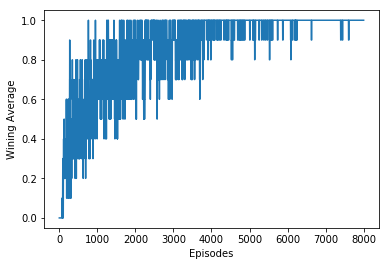

<IPython.core.display.Math object>

[[  1.13906250e-05   7.59375000e-05   7.59375000e-05   1.13906250e-05]
 [  1.13906250e-05   0.00000000e+00   5.06250000e-04   7.59375000e-05]
 [  7.59375000e-05   3.37500000e-03   7.59375000e-05   5.06250000e-04]
 [  5.06250000e-04   0.00000000e+00   7.59271434e-05   7.59374994e-05]
 [  7.59375000e-05   5.06250000e-04   0.00000000e+00   1.13906250e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.25000000e-02   0.00000000e+00   7.67497927e-08]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.06250000e-04   0.00000000e+00   3.37500000e-03   7.59375000e-05]
 [  0.00000000e+00   0.00000000e+00   2.25000000e-02   0.00000000e+00]
 [  0.00000000e+00   1.50000000e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.

<IPython.core.display.Math object>

[[  7.59375000e-05   5.06250000e-04   3.37500000e-03   5.06250000e-04]
 [  5.06250000e-04   0.00000000e+00   2.25000000e-02   0.00000000e+00]
 [  3.37500000e-03   2.25000000e-02   1.50000000e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00]]


<IPython.core.display.Math object>

[['D' 'R' 'D' 'L']
 ['D' 'H' 'D' 'H']
 ['R' 'R' 'D' 'H']
 ['H' 'X' 'R' 'X']]


In [632]:
# Si 'y' es bajo, los valores de Q tardan mas en pasar 'np.random.randn(1,env.action_space.n)*(1./(i+1))'
# Por lo tanto se prueban mas opciones.
# Se confia menos en las recompenzas futuras

num_episodes = 8000
Q_ns_table_2, acummulated_average_ns_table_2, _ = estimate_Q(env_not_slippery, 
                                           num_episodes=num_episodes, 
                                           y = 0.15, MA_window = 10, debug=False)
show_results(Q_ns_table_2, acummulated_average_ns_table_2)

# Slippery

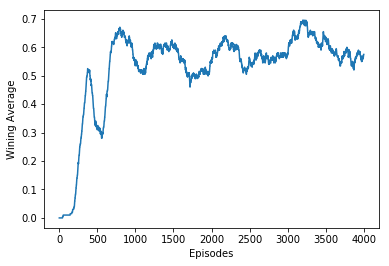

<IPython.core.display.Math object>

[[  1.17218194e-01   3.18901346e-03   8.09736050e-03   4.26641774e-03]
 [  8.84161761e-04   5.32904078e-04   1.68440341e-03   9.60555880e-02]
 [  2.39098642e-03   6.30328206e-03   5.66372169e-03   1.48735061e-01]
 [  8.00064004e-04   1.36561370e-04   1.30803510e-03   6.02680514e-02]
 [  2.70094794e-01   1.60108582e-04   1.23790610e-04   3.64890551e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.05560747e-01   4.89412977e-07   1.04506194e-05   2.62560851e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.76737569e-04   4.77677968e-04   6.25502305e-03   1.99332281e-01]
 [  0.00000000e+00   6.94511367e-02   1.42101498e-03   7.09201223e-04]
 [  7.22460620e-01   1.28070679e-04   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.54128455e-02   0.00000000e+00]
 [  0.

<IPython.core.display.Math object>

[[ 0.11721819  0.09605559  0.14873506  0.06026805]
 [ 0.27009479  0.          0.10556075  0.        ]
 [ 0.19933228  0.06945114  0.72246062  0.        ]
 [ 0.          0.09541285  0.95113561  0.        ]]


<IPython.core.display.Math object>

[['L' 'U' 'U' 'U']
 ['L' 'H' 'L' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'U' 'X']]


In [459]:
# Si y es bajo, los valores de Q tardan mas en pasar 
# np.random.randn(1,env.action_space.n)*(1./(i+1))
num_episodes = 4000
Q_s_table, acummulated_average_s_table, _ = estimate_Q(env, 
                                           num_episodes=num_episodes, 
                                           y = 0.95, MA_window = 200, debug=False)
show_results(Q_s_table, acummulated_average_s_table)

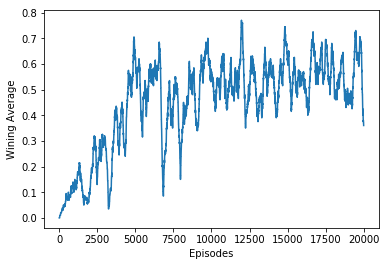

<IPython.core.display.Math object>

[[  9.75707846e-05   1.22093874e-04   4.62771964e-03   8.73916321e-05]
 [  5.87868914e-06   1.33586659e-05   1.61587484e-05   2.35508276e-04]
 [  8.17143292e-05   6.07778537e-05   3.60396358e-03   1.10985477e-04]
 [  2.27113049e-07   3.96196152e-06   1.74864853e-06   8.03038399e-05]
 [  1.55032192e-02   7.72628368e-05   1.09276609e-05   1.21836210e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.79958323e-06   6.48628392e-05   4.21039467e-01   1.74594383e-07]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.03071878e-05   6.00876022e-07   7.45083671e-05   7.18633073e-02]
 [  8.34940159e-05   4.41248129e-01   2.78190537e-05   9.82507071e-05]
 [  1.58031878e-01   1.43573092e-06   1.65943379e-05   5.25386735e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.29845126e-04   7.39735273e-04   4.39953450e-01   0.00000000e+00]
 [  0.

<IPython.core.display.Math object>

[[  4.62771964e-03   2.35508276e-04   3.60396358e-03   8.03038399e-05]
 [  1.55032192e-02   0.00000000e+00   4.21039467e-01   0.00000000e+00]
 [  7.18633073e-02   4.41248129e-01   1.58031878e-01   0.00000000e+00]
 [  0.00000000e+00   4.39953450e-01   9.01227525e-01   0.00000000e+00]]


<IPython.core.display.Math object>

[['R' 'U' 'R' 'U']
 ['L' 'H' 'R' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'D' 'X']]


In [460]:
num_episodes = 20000
Q_s_table_1, acummulated_average_s_table_1, _ = estimate_Q(env, 
                                           num_episodes=num_episodes, 
                                           y = 0.8, MA_window = 200, debug=False)
show_results(Q_s_table_1, acummulated_average_s_table_1)

# Neural Network Q aproximation

- Entrada: ont-hot 1x16
- Capa densa con 14x4 pasos
- Salida: L, D, R, U

Algoritmo:
- Inicializo pesos de la red neuronal aleatoriamente
- Ingreso con el estado inicial $s_0$
- Me devuelve un listado de posibles acciones con sus pesos: $q(s_0, a)$
- Elijo la accion mas probable a_0 (Con un grado de aleatoriedad que va disminuyendo con cada episodio) y guardo el valor $maxQ_0$ (valor de Q para esa accion)
- Ejecuto la accion y tengo un nuevo estado $S_1$ con un posible reward $r_1$
- Ingreso a la RNN con ese nuevo estado, obtengo $q(s_1,a)$ y me quedo con el valor mayor ($maxQ_1$)
- Uso $maxQ_1$ para predecir el anterior $maxQ_0$: $r_1+\gamma maxQ_1$
- Es decir, le pido que haga un update de los pesos con entrada $s_0$ y salida $maxQ_0$ (Target, valor anotado)
- Repito esto hasta que termina el juego (suponiendo que termina)
- repito esto tantos episodios como sean necesarios

In [571]:
def estimate_NN_Q(env, num_episodes = 4000, y = .99, MA_window = 400, lr=0.1, random_bias=10, inv_sigma = 50):
    tf.reset_default_graph()
    #These lines establish the feed-forward part of the network used to choose actions
    inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
    W = tf.Variable(tf.random_uniform([16,4],0,0.01))
    Qout = tf.matmul(inputs1,W)
    predict = tf.argmax(Qout,1)

    #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
    nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    #trainer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    trainer = tf.train.AdamOptimizer()
    updateModel = trainer.minimize(loss)
    init = tf.global_variables_initializer()
    acummulated_average = []
    #create lists to contain total rewards and steps per episode
    jList = []
    rList = []
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_episodes):
            #Reset environment and get first new observation
            s = env.reset()
            rAll = 0
            d = False
            j = 0
            #The Q-Network
            while j < 99:
                j+=1
                #Choose an action by greedily (with e chance of random action) from the Q-network
                a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
                #a no lo estoy usando. Solo uso allQ que es la Q para el estado s de todas las acciones posibles

                a = np.argmax(allQ + np.random.randn(1,env.action_space.n)*(1./((i/inv_sigma) + random_bias)))
                a = np.array([a])
                #en a esta la proxima accion
                #Get new state and reward from environment
                s1,r,d,_ = env.step(a[0])
                #Obtain the Q' values by feeding the new state through our network
                Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
                #Obtain maxQ' and set our target value for chosen action.
                maxQ1 = np.max(Q1)
                targetQ = allQ
                targetQ[0,a[0]] = r + y*maxQ1
                #Train our network using target and predicted Q values
                _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
                rAll += r
                s = s1
                if d == True:
                    break
            jList.append(j)
            rList.append(rAll)
            acummulated_average.append(float(sum(rList[-MA_window:]))/MA_window)
        Q = []
        for i in range(16):
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[i:i+1]})
            Q.append(allQ[0])
        Q = np.array(Q)
    return Q, acummulated_average, rList

# Slippery

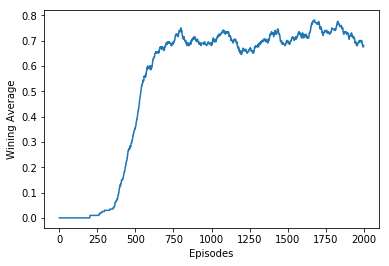

<IPython.core.display.Math object>

[[  5.23122132e-01   1.34310901e-01   2.17843533e-01   4.80615497e-01]
 [  1.28176123e-01   1.63677167e-02   1.55931525e-02   4.86903340e-01]
 [  6.44522235e-02   1.23475410e-01   5.62990233e-02   4.50413525e-01]
 [  3.00608110e-02   7.64504448e-03   2.78969016e-02   4.25047845e-01]
 [  5.49690843e-01   3.69653180e-02   2.10792925e-02   3.40822861e-02]
 [  2.71950359e-03   3.68393050e-03   6.65705325e-03   2.08523270e-04]
 [  1.01719974e-02   4.08865698e-02   3.31176251e-01  -7.67790247e-03]
 [  7.15300301e-03   2.05322503e-04   4.19854745e-03   7.71735283e-03]
 [  2.25963797e-02   2.28811074e-02   6.81121498e-02   5.86594343e-01]
 [  1.47740198e-02   6.20261133e-01   9.38512012e-03   1.82526205e-02]
 [  5.62005818e-01   9.66963358e-04   8.29931814e-03   3.48402262e-02]
 [  5.26902080e-03   4.31954628e-03   6.81273546e-03   3.97503469e-03]
 [  4.09933552e-03   6.23953203e-03   1.84317585e-03   4.48188419e-03]
 [  9.07629321e-04  -5.83852315e-03   7.42117465e-01   3.90845202e-02]
 [  6.

<IPython.core.display.Math object>

[[ 0.52312213  0.48690334  0.45041353  0.42504784]
 [ 0.54969084  0.00665705  0.33117625  0.00771735]
 [ 0.58659434  0.62026113  0.56200582  0.00681274]
 [ 0.00623953  0.74211746  0.86433363  0.00618159]]


<IPython.core.display.Math object>

[['L' 'U' 'U' 'U']
 ['L' 'H' 'R' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'D' 'R']]


In [547]:
# notar aca el random_bias = 50. 
Q_nn_s, acummulated_average_nn_s, _ = estimate_NN_Q(env, num_episodes = 2000, 
                                                    y = .99, 
                                                    MA_window = 200, 
                                                    lr=0.05,
                                                   random_bias=50)
show_results(Q_nn_s, acummulated_average_nn_s)

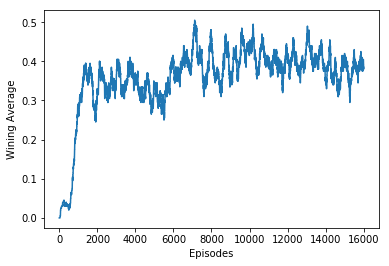

<IPython.core.display.Math object>

[[  5.00415489e-02   2.04079971e-02   1.21239247e-02   1.59278009e-02]
 [  7.68215745e-04   2.50725672e-02  -2.49153320e-02  -7.35264504e-03]
 [ -7.71684386e-03   5.60887530e-02  -2.55913648e-04  -2.43232548e-02]
 [ -2.12381035e-02  -1.55753493e-02  -1.54144885e-02   4.78096977e-02]
 [  6.46848604e-02   1.59747358e-02   1.12502734e-04  -2.44090334e-03]
 [  1.48645637e-03   3.92428134e-03   7.75015680e-03   6.07650029e-03]
 [ -8.80375598e-03   7.27038272e-03   9.21690464e-02   3.59111303e-03]
 [  8.07489175e-03   7.17069721e-03   6.68151025e-03   4.51685768e-03]
 [  2.92449025e-03   2.07376145e-02   1.93553958e-02   9.40087140e-02]
 [ -4.49203607e-03   1.69852391e-01   1.76093858e-02   2.56772637e-02]
 [  2.27978006e-01   8.91405344e-03   1.48527119e-02  -6.51614182e-03]
 [  2.61981250e-03   3.62755521e-03   7.31496559e-03   3.77579080e-03]
 [  2.72909156e-03   1.47045136e-03   6.50773756e-03   3.15464125e-03]
 [  1.80861112e-02   2.44701847e-01  -3.77494539e-03  -2.97444087e-04]
 [  2.

<IPython.core.display.Math object>

[[ 0.05004155  0.02507257  0.05608875  0.0478097 ]
 [ 0.06468486  0.00775016  0.09216905  0.00807489]
 [ 0.09400871  0.16985239  0.22797801  0.00731497]
 [ 0.00650774  0.24470185  0.54756933  0.00790789]]


<IPython.core.display.Math object>

[['L' 'D' 'D' 'U']
 ['L' 'H' 'R' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'D' 'R' 'D']]


In [589]:
# notar aca el random_bias = 50. 
Q_nn_s, acummulated_average_nn_s, _ = estimate_NN_Q(env, num_episodes = 16000, 
                                                    y = .9, 
                                                    MA_window = 200, 
                                                    lr=0.05,
                                                   random_bias=100,
                                                   inv_sigma = 30)
show_results(Q_nn_s, acummulated_average_nn_s)

# Non-slippery

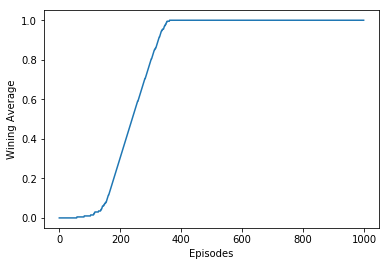

<IPython.core.display.Math object>

[[  9.52819288e-01   4.37318921e-01   9.59670126e-01   9.50073481e-01]
 [  9.50070441e-01   2.80972868e-02   9.69363749e-01   9.59670126e-01]
 [  7.04075873e-01   9.79155302e-01   5.29673815e-01   9.69302773e-01]
 [  5.73419213e-01  -4.24969150e-03   3.43944699e-01   4.51859951e-01]
 [  3.87622356e-01   3.66403431e-01   5.02041599e-04   4.80027735e-01]
 [  8.80080182e-03   4.90567181e-03   8.25699419e-03   7.83471204e-03]
 [  1.78513881e-02   9.89045739e-01  -5.54831792e-03   9.68908250e-01]
 [  6.31559594e-03   4.88144485e-03   2.16512801e-03   2.52453680e-03]
 [  3.56134295e-01  -7.89505802e-03   3.80663723e-01   3.45896035e-01]
 [  3.14528197e-01   7.03983903e-02   4.13149446e-01  -3.44761857e-03]
 [  2.45116547e-01   9.99036014e-01   2.28203535e-02   4.56089348e-01]
 [  5.55860251e-03   8.95954017e-03   9.88973584e-03   1.21348503e-03]
 [  3.14963097e-03   4.01825644e-03   2.49934779e-03   1.58255931e-03]
 [ -1.92337595e-02   4.94731739e-02   1.20856807e-01   3.79306972e-02]
 [  5.

<IPython.core.display.Math object>

[[ 0.95967013  0.96936375  0.9791553   0.57341921]
 [ 0.48002774  0.0088008   0.98904574  0.0063156 ]
 [ 0.38066372  0.41314945  0.99903601  0.00988974]
 [ 0.00401826  0.12085681  1.00912726  0.00921982]]


<IPython.core.display.Math object>

[['R' 'R' 'D' 'L']
 ['U' 'H' 'D' 'H']
 ['R' 'R' 'D' 'H']
 ['H' 'R' 'R' 'D']]


In [541]:
Q_nn_ns, acummulated_average_nn_ns, _ = estimate_NN_Q(env_not_slippery, 
                                                      num_episodes = 1000, 
                                                      y = .99,
                                                      MA_window = 200, 
                                                      lr=0.1)
show_results(Q_nn_ns, acummulated_average_nn_ns)

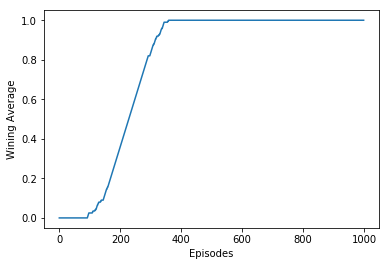

<IPython.core.display.Math object>

[[ -1.87940197e-03   3.13825905e-02   3.11674997e-02   2.57134996e-03]
 [ -2.00746884e-03  -6.59644371e-03   6.27862886e-02   5.61637525e-03]
 [ -9.34842601e-03   1.25419974e-01  -3.93773749e-04  -1.94509551e-02]
 [ -1.05848527e-02   7.59180123e-03  -9.52114072e-03  -1.44922081e-02]
 [ -1.38244526e-02   6.27349317e-02   3.10520525e-03  -2.87720072e-03]
 [  1.21973874e-03   9.32347757e-05   8.25640652e-03   3.35931763e-05]
 [ -2.85885902e-03   2.50994802e-01   3.57388612e-03  -5.07893227e-03]
 [  8.10754392e-03   1.92164653e-03   4.37934510e-03   2.15274934e-03]
 [  5.40488516e-04   8.94623250e-03   1.25468805e-01  -8.34850781e-03]
 [ -9.11110919e-03  -1.57039743e-02   2.50943780e-01  -4.83377418e-03]
 [  3.23303812e-03   5.01887858e-01   5.50313201e-03  -4.11101058e-03]
 [  6.94081746e-03   5.23427362e-03   2.52863765e-03   5.45987720e-03]
 [  8.28193780e-03   7.08950742e-04   3.42454552e-03   9.35504213e-03]
 [ -1.13042966e-02  -1.25945294e-02   2.29903646e-02  -6.73942873e-03]
 [ -1.

<IPython.core.display.Math object>

[[ 0.03138259  0.06278629  0.12541997  0.0075918 ]
 [ 0.06273493  0.00825641  0.2509948   0.00810754]
 [ 0.12546881  0.25094378  0.50188786  0.00694082]
 [ 0.00935504  0.02299036  1.00377584  0.00761027]]


<IPython.core.display.Math object>

[['D' 'R' 'D' 'D']
 ['D' 'H' 'D' 'H']
 ['R' 'R' 'D' 'H']
 ['H' 'R' 'R' 'R']]


In [568]:
Q_nn_ns, acummulated_average_nn_ns, _ = estimate_NN_Q(env_not_slippery, 
                                                      num_episodes = 1000, 
                                                      y = .5,
                                                      MA_window = 200, 
                                                      lr=0.1,
                                                     random_bias=200)
show_results(Q_nn_ns, acummulated_average_nn_ns)